### 1. Import Libraries
This cell imports all the necessary libraries for the notebook. 
- **numpy**: For numerical operations and creating arrays.
- **matplotlib.pyplot & seaborn**: For data visualization and plotting decision boundaries.
- **sklearn**: For machine learning tasks, including:
  - `make_moons`: To generate a synthetic non-linear dataset.
  - `train_test_split`: To split the data into training and testing sets.
  - `GridSearchCV`: To perform an exhaustive search over specified parameter values for an estimator.
  - `StandardScaler`: To standardize features by removing the mean and scaling to unit variance.
  - `SVC`: The Support Vector Classification model.
  - `classification_report` & `confusion_matrix`: For evaluating the model's performance.

In [1]:
# Import necessary libraries for data manipulation, visualization, and machine learning.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import specific modules from scikit-learn.
from sklearn.datasets import make_moons  # To generate a non-linear dataset.
from sklearn.model_selection import train_test_split, GridSearchCV  # For splitting data and hyperparameter tuning.
from sklearn.preprocessing import StandardScaler  # For feature scaling.
from sklearn.svm import SVC  # Support Vector Classifier.
from sklearn.metrics import classification_report, confusion_matrix  # For model evaluation.

### 2. Generate Non-linear Data
Here, we use `make_moons` to create a dataset that is not linearly separable. This is a classic dataset for demonstrating the power of kernel SVMs.
- `n_samples=500`: Creates 500 data points.
- `noise=0.2`: Adds some random noise to the data points, making the classification task more realistic and challenging.
- `random_state=42`: Ensures that the same dataset is generated every time the code is run, for reproducibility.

In [2]:
# Step 1: Generate Non-linear Data
# Create a synthetic dataset of two interleaving half circles (moons).
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

### 3. Preprocessing the Data
SVMs are sensitive to the scale of the features. If one feature has a much larger range than others, it will dominate the distance calculation. `StandardScaler` standardizes the features (mean=0, variance=1), ensuring that all features contribute equally to the model's training.

In [3]:
# Step 2: Preprocessing
# Initialize the StandardScaler.
scaler = StandardScaler()
# Fit the scaler to the data and transform it, standardizing the features.
X_scaled = scaler.fit_transform(X)

### 4. Visualize the Dataset
This plot shows the raw `make_moons` data. The two colors represent the two classes. It's clear from the plot that a straight line cannot effectively separate the blue and red points, highlighting the need for a non-linear model.

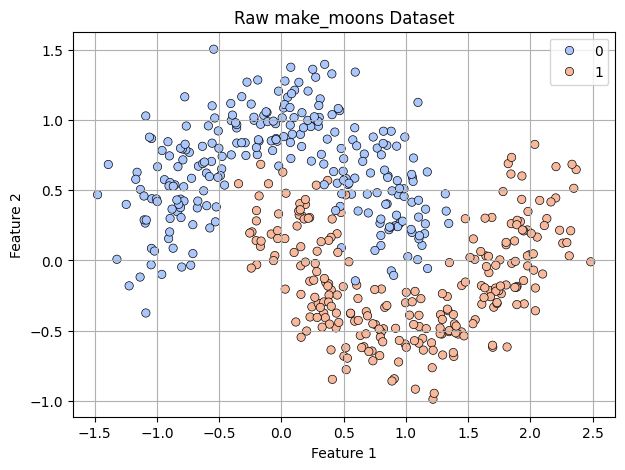

In [4]:
# Visualize the original dataset before training
plt.figure(figsize=(7, 5))
# Create a scatter plot of the data points, colored by their class (y).
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', edgecolor='k')
plt.title("Raw make_moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

### 5. Split Data into Training and Testing Sets
The dataset is split into two parts: a training set (80%) to train the model, and a testing set (20%) to evaluate its performance on unseen data. 
- `stratify=y`: This ensures that the training and test sets have the same proportion of examples from each class as the original dataset.

In [5]:
# Split the scaled data into training and testing sets (80% train, 20% test).
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### 6. Set Up the Grid Search for Hyperparameter Tuning
To find the best SVM model, we need to tune its hyperparameters. We define a `param_grid` dictionary to specify the range of values to test for the RBF kernel.
- `'C'`: The regularization parameter. It controls the trade-off between achieving a low training error and a low testing error.
- `'gamma'`: The kernel coefficient for 'rbf'. It defines how much influence a single training example has.
- `'kernel'`: We specify `'rbf'` (Radial Basis Function), which is a powerful kernel for non-linear data.

In [6]:
# Step 4: Define the parameter grid for GridSearchCV.
# This dictionary contains the hyperparameters and their values to be tested.
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter.
    'gamma': [0.01, 0.1, 1], # Kernel coefficient.
    'kernel': ['rbf']         # We are focusing on the RBF kernel.
}

### 7. Perform Grid Search with Cross-Validation
`GridSearchCV` will train an SVM model for every combination of `C` and `gamma` values in the `param_grid`. 
- `cv=5`: It uses 5-fold cross-validation for each combination. The data is split into 5 folds; the model is trained on 4 and validated on the 5th, repeating this process 5 times.
- `scoring='accuracy'`: The performance of each model is judged based on its accuracy.
Finally, it identifies and prints the best parameters and the corresponding cross-validation score.

In [7]:
# Initialize GridSearchCV with the SVC model, parameter grid, and 5-fold cross-validation.
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data to find the best hyperparameters.
grid_search.fit(X_train, y_train)

# Print the best parameters found by the grid search.
print("Best Parameters from GridSearchCV:")
print(grid_search.best_params_)

# Print the accuracy score of the best model on the cross-validation set.
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters from GridSearchCV:
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.975


### 8. Evaluate the Best Model on the Test Set
Using the best estimator found by `GridSearchCV`, we make predictions on the held-out test data. We then print:
- **Classification Report**: Shows precision, recall, and F1-score for each class, giving a detailed view of the model's performance.
- **Confusion Matrix**: Shows the number of correct and incorrect predictions for each class (True Positives, True Negatives, False Positives, False Negatives).

In [8]:
# Step 5: Evaluate the best model found by grid search.
# Get the best model from the grid search.
best_model = grid_search.best_estimator_

# Make predictions on the test set.
y_pred = best_model.predict(X_test)

# Print a detailed classification report.
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix to see the number of correct/incorrect predictions.
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        50
           1       0.98      0.98      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

Confusion Matrix:
[[49  1]
 [ 1 49]]


### 9. Define a Function to Plot the Decision Boundary
This helper function visualizes the decision boundary of a trained classifier. 
1. It creates a mesh grid of points spanning the range of the features.
2. It uses the trained `model` to predict the class for every point on this grid.
3. It plots the predicted classes as a colored background (`contourf`). The line where the colors change is the decision boundary.
4. It overlays the original data points on top of the background to show how well the model separates them.

In [9]:
# Step 6: Decision Boundary Plot Function
def plot_decision_boundary(model, X, y, title):
    # Create a mesh of points to plot in
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', edgecolor='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

### 10. Visualize the RBF Kernel SVM Decision Boundary
This plot shows the non-linear decision boundary created by the best RBF kernel SVM. The boundary smoothly curves to correctly classify the two moon-shaped clusters, demonstrating its effectiveness on this dataset.

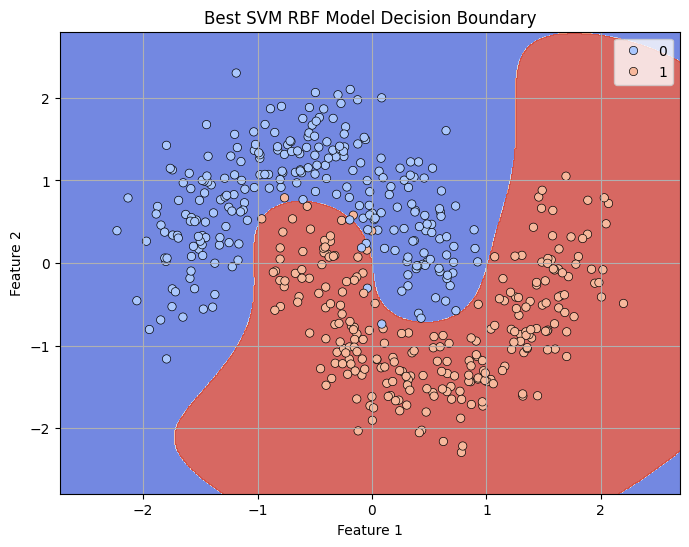

In [10]:
# Step 7: Visualize the decision boundary of the best model (RBF kernel).
plot_decision_boundary(best_model, X_scaled, y, "Best SVM RBF Model Decision Boundary")

### 11. Train and Evaluate a Polynomial Kernel SVM
For comparison, we now train an SVM with a polynomial kernel (`degree=3`). This is another type of non-linear kernel. We train it, evaluate its performance, and visualize its decision boundary to see how it compares to the RBF kernel.

Polynomial Kernel SVM Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84        50
           1       0.81      0.92      0.86        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

Confusion Matrix:
[[39 11]
 [ 4 46]]


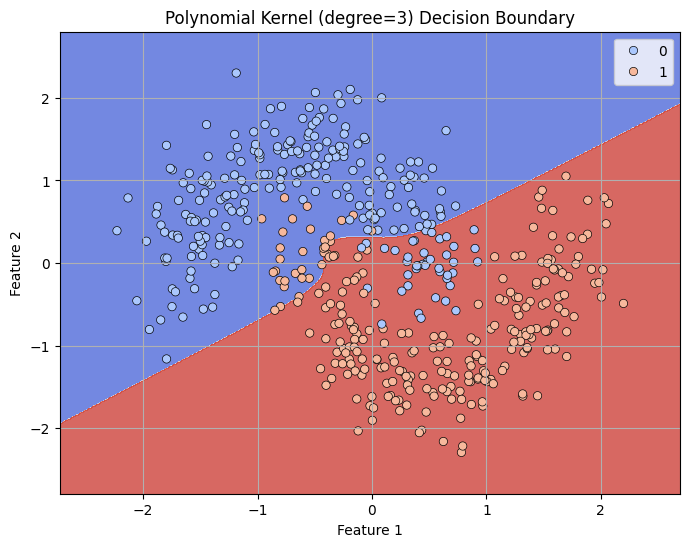

In [11]:
# Train a Polynomial Kernel SVM for comparison.
# We use a degree of 3 for the polynomial.
poly_svm = SVC(kernel='poly', degree=3, C=1.0)
poly_svm.fit(X_train, y_train)

# Predict and evaluate the polynomial model.
y_poly_pred = poly_svm.predict(X_test)

# Print the classification report and confusion matrix.
print("Polynomial Kernel SVM Report:")
print(classification_report(y_test, y_poly_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_poly_pred))

# Plot the decision boundary for the polynomial kernel SVM.
plot_decision_boundary(poly_svm, X_scaled, y, "Polynomial Kernel (degree=3) Decision Boundary")

### 12. Train and Evaluate a Linear SVM
Finally, we train a standard linear SVM. This model can only create a straight-line decision boundary. The resulting plot clearly shows that a linear boundary is inadequate for this dataset, leading to poor classification performance, which reinforces why non-linear kernels are necessary for such problems.

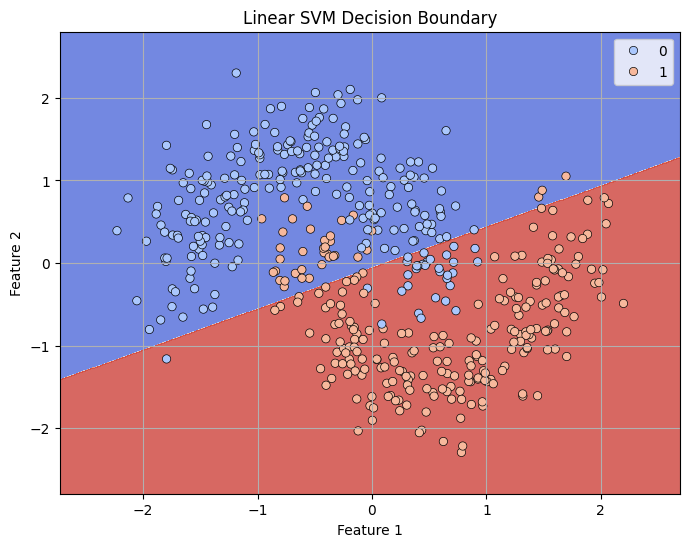

In [12]:
# Train a linear SVM for comparison.
linear_svm = SVC(kernel='linear', C=1.0)
linear_svm.fit(X_train, y_train)

# Visualize the decision boundary of the Linear SVM.
# This will illustrate why a linear model is not suitable for this dataset.
plot_decision_boundary(linear_svm, X_scaled, y, "Linear SVM Decision Boundary")